In [2]:
import pandas as pd
import numpy as np
import sys
import os
sys.path.append("../data/")



In [3]:
diabetes = pd.read_csv("data/Diabetes_Data_1999_2008.csv")
Discharge_Disposition = pd.read_csv('data/Discharge_Disposition_Mapping.csv')
Admission_Type_Mapping = pd.read_csv('data/Admission_Type_Mapping.csv')
Admission_Source_Mapping = pd.read_csv('data/Admission_Source_Mapping.csv')


data_cleaned = pd.read_csv('data/diabetic_data_prelim_cleaned.csv').set_index('patient_nbr').iloc[:,2:]
data_cleaned = data_cleaned.loc[:,~data_cleaned.columns.isin(['weight','payer_code','medical_specialty','diag_1',
                                                              'diag_2','diag_3','readmitted'])]
data_cleaned = data_cleaned[(data_cleaned.race=='Caucasian')|(data_cleaned.race=='AfricanAmerican')]
#Group1 = list(data_cleaned.groupby('race'))[0][1]
#Group2 = list(data_cleaned.groupby('race'))[1][1]

FileNotFoundError: [Errno 2] File data/Diabetes_Data_1999_2008.csv does not exist: 'data/Diabetes_Data_1999_2008.csv'

In [284]:
data_cleaned.columns

Index(['race', 'gender', 'age', 'admission_type_id',
       'discharge_disposition_id', 'admission_source_id', 'time_in_hospital',
       'num_lab_procedures', 'num_procedures', 'num_medications',
       'number_outpatient', 'number_emergency', 'number_inpatient',
       'number_diagnoses', 'max_glu_serum', 'A1Cresult', 'metformin',
       'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride',
       'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
       'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
       'tolazamide', 'examide', 'citoglipton', 'insulin',
       'glyburide.metformin', 'glipizide.metformin',
       'glimepiride.pioglitazone', 'metformin.rosiglitazone',
       'metformin.pioglitazone', 'change', 'diabetesMed', 'diag_1_grouped',
       'early_readmitted'],
      dtype='object')

In [316]:
from sklearn.preprocessing import OneHotEncoder
catogory_columns = [ 'gender', 'age', 'admission_type_id','admission_source_id',
                    'diag_1_grouped','max_glu_serum', 'A1Cresult','metformin', 'repaglinide', 'nateglinide',
       'chlorpropamide', 'glimepiride', 'acetohexamide', 'glipizide',
       'glyburide', 'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose',
       'miglitol', 'troglitazone', 'tolazamide', 'examide', 'citoglipton',
       'insulin', 'glyburide.metformin', 'glipizide.metformin',
       'glimepiride.pioglitazone', 'metformin.rosiglitazone',
       'metformin.pioglitazone', 'change','diabetesMed']


def onehoter_transform(catogory_columns, data_cleaned):
    encoder = OneHotEncoder(handle_unknown='ignore')

    encoder_df = pd.DataFrame(encoder.fit_transform(data_cleaned[catogory_columns]).toarray(),index=data_cleaned.index)

    one_hot_new_colums = []
    for origin_name, i in zip(catogory_columns,encoder.categories_):
        l = np.array(list(map(lambda x:str(x)+'_'+str(origin_name),i)))
        one_hot_new_colums.append(l)
    one_hot_new_colums = np.concatenate(one_hot_new_colums)

    encoder_df.columns = one_hot_new_colums

    final_df = data_cleaned.loc[:,~data_cleaned.columns.isin(catogory_columns)].join(encoder_df)
    return final_df

final_df = onehoter_transform(catogory_columns,data_cleaned)
final_df1 = final_df[final_df.race == 'Caucasian']
final_df2 = final_df[final_df.race == 'AfricanAmerican']

final_df1 = pd.concat([final_df1[final_df1.early_readmitted==1],
                       final_df1[final_df1.early_readmitted==0].iloc[:len(final_df1[final_df1.early_readmitted==1]),:]],
                       axis = 0)

final_df2 = pd.concat([final_df2[final_df2.early_readmitted==1],
                       final_df2[final_df2.early_readmitted==0].iloc[:len(final_df2[final_df2.early_readmitted==1]),:]],
                       axis = 0)


X1 = final_df1.loc[:,~final_df1.columns.isin(['early_readmitted','race'])]
Y1 = final_df1.early_readmitted

X2 = final_df2.loc[:,~final_df2.columns.isin(['early_readmitted','race'])]
Y2 = final_df2.early_readmitted



In [261]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold

pipeline = Pipeline([('randomforest', RandomForestClassifier())])
test_size = 0.2
cv = KFold(n_splits=5, shuffle=True)


search = GridSearchCV(pipeline, {
    'randomforest__n_estimators': [100, 150],
    'randomforest__criterion': ['gini','entropy'],
    'randomforest__max_depth':[10, 15, 20],
    
}, refit=True, cv=cv, n_jobs=-1)
search.fit(X1, Y1)
Best_param1 = search.best_params_
search.fit(X2, Y2)
Best_param2 = search.best_params_

In [285]:
Best_param1

{'randomforest__criterion': 'gini',
 'randomforest__max_depth': 10,
 'randomforest__n_estimators': 100}

In [319]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import LeaveOneOut
RF = RandomForestClassifier(n_estimators=100,criterion='gini',max_depth=10)
cv = KFold(n_splits=10, shuffle=True)
scores1 = cross_val_score(RF, X1, Y1, cv=cv)
scores2 = cross_val_score(RF, X2, Y2, cv=cv)


In [320]:
RF.fit(X2,Y2)
feature_importance2 = RF.feature_importances_
Y1_predict = RF.predict(X1)
diff_group1 = Y1 - Y1_predict
RF.fit(X1,Y1)
feature_importance1 = RF.feature_importances_
Y2_predict = RF.predict(X2)
diff_group2 = Y2 - Y2_predict

In [326]:
Feature_impr = pd.Series(RF.feature_importances_, index=X1.columns)
Feature_impr.sort_values(ascending=False)

NameError: name 'group2' is not defined

Text(0.5, 1.0, 'Use African American data to predict Caucasian early readmission ')

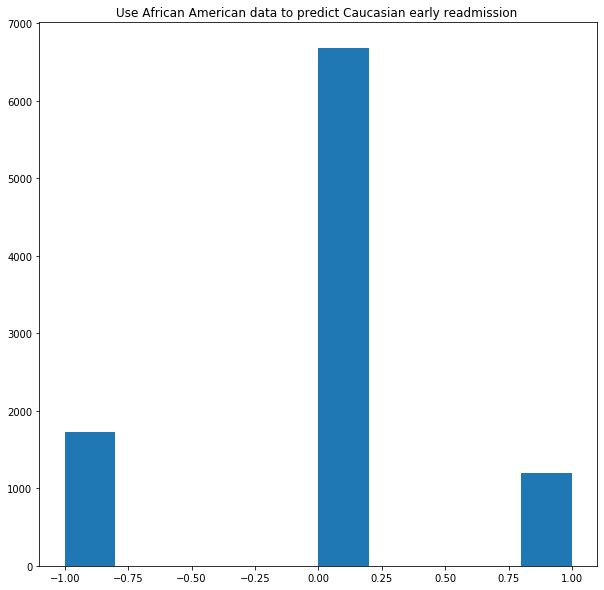

In [334]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
plt.hist(diff_group1)
plt.title('Use African American data to predict Caucasian early readmission ')

Text(0.5, 1.0, 'Use Caucasian data to predict African American early readmission ')

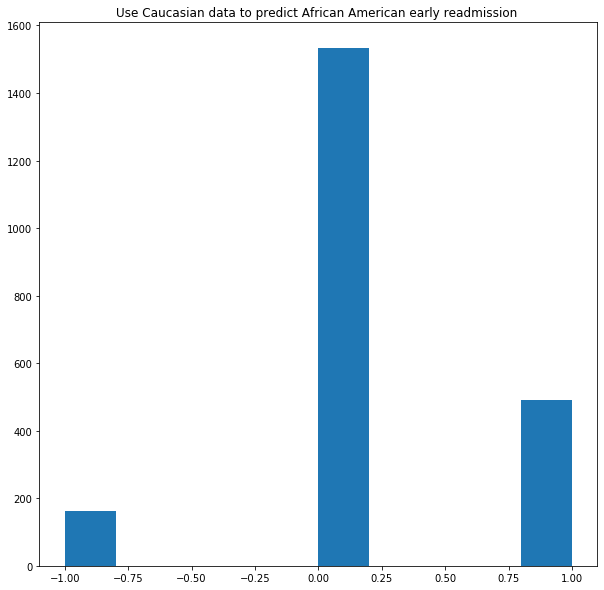

In [333]:
plt.figure(figsize=(10,10))
plt.hist(diff_group2)
plt.title('Use Caucasian data to predict African American early readmission ')

In [324]:
scores1 

array([0.70967742, 0.71488033, 0.73541667, 0.728125  , 0.72604167,
       0.728125  , 0.71458333, 0.72395833, 0.73020833, 0.72708333])